# LRAN control model prototyping

### Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
from keras.models import Model
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pickle
from cvxopt import matrix
from cvxopt import solvers
from scipy.linalg import solve_discrete_are
from scipy.optimize import minimize
import keras
import tensorflow as tf
from keras import backend as K
import sys

import time
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, AutoEncoderDataGenerator, DataGenerator
from helpers.custom_losses import normed_mse, mean_diff_sum_2, max_diff_sum_2, mean_diff2_sum2, max_diff2_sum2, denorm_loss, hinge_mse_loss, percent_correct_sign, baseline_MAE
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import copy
from tqdm import tqdm_notebook
from helpers.normalization import normalize, denormalize, renormalize
import scipy
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image, display
from helpers.custom_init import downsample
from helpers.custom_reg import groupLasso
import helpers
from tqdm import tqdm

Using TensorFlow backend.
/home/aaronwu/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aaronwu/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aaronwu/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aaronwu/.conda/envs/tfg

In [5]:
# Plotting setup
%matplotlib inline
font={'family': 'DejaVu Serif',
      'size': 18}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
# for i,c in enumerate(colorblind_colors):
#     plt.plot((i)*np.ones(5),c=c)

eq_sigs = {'temp':'etemp',
         'thomson_temp_EFITRT1':'etemp',
         'thomson_temp_EFITRT2':'etemp',
         'dens':'edens',
         'thomson_dens_EFITRT1':'edens',
         'thomson_dens_EFITRT2':'edens',
         'itemp':'itemp',
         'cerquick_temp_EFITRT1':'itemp',
         'cerquick_temp_EFITRT2':'itemp',
         'rotation':'rotation',
         'cerquick_rotation_EFITRT1':'rotation',
         'cerquick_rotation_EFITRT2':'rotation',
         'press_EFITRT1':'press',
         'press_EFITRT2':'press',
         'press_EFIT01':'press',
         'press_EFIT02':'press',
         'ffprime_EFITRT1':'ffprime',
         'ffprime_EFITRT2':'ffprime',
         'ffprime_EFIT01':'ffprime',
         'ffprime_EFIT02':'ffprime',
         'q':'q',
         'q_EFITRT1':'q',
         'q_EFITRT2':'q',
         'q_EFIT01':'q',
         'q_EFIT02':'q'}

labels = {'edens': '$n_e$ ($10^{19}/m^3$)',
          'etemp': '$T_e$ (keV)',
          'itemp': '$T_i$ (keV)',
          'rotation':'$\Omega$ (kHz)',
          'q':'$\iota$',
          'press':'$P$ (Pa)',
         'ffprime':"$FF'$"}

labels = {key:labels[val] for key, val in eq_sigs.items()}

scatter_titles = {'mean':'Mean',
                  'std':'Std Dev.',
                  'pca_1':'PCA Mode 1',
                  'pca_2':'PCA Mode 2',
                  'pca_3':'PCA Mode 3',
                  'pca_4':'PCA Mode 4',
                  'pca_5':'PCA Mode 5',
                  'pca_6':'PCA Mode 6',
                  'pca_2':'PCA Mode 2'}


### Load Files and Model

In [2]:
# Azmaine's models. Don't know which one he decided was most optimal.

### Run Results 04_10
# Model 7 (layer scale = 2), lookahead = 6
# model_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-18-37_Scenario-7.h5'
# scenario_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-18-37_Scenario-7_params.pkl'

# Model 2 (layer scale = 1), lookahead = 6
#model_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-17-25_Scenario-2.h5'
#scenario_path = '/home/aiqtidar/run_results_04_10/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-6_10Apr21-17-25_Scenario-2_params.pkl'

# Some Model
#model_path = '/home/aiqtidar/run_results_04_8/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-6_09Apr21-00-40_Scenario-11.h5'
#scenario_path = '/home/aiqtidar/run_results_04_8/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-6_09Apr21-00-40_Scenario-11_params.pkl'

# Aaron's Ideal Hyperparam, lookahead = 4
# scenario_path = '/home/aiqtidar/run_results_04_15_Aaron_Best/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-4_15Apr21-13-36_Scenario-0_params.pkl'
# model_path = '/home/aiqtidar/run_results_04_15_Aaron_Best/final_model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_LB-0_LA-4_15Apr21-13-36_Scenario-0.h5'
# 
# Aaron's Best Model 2, given by Rory
# model_path = '/home/aaronwu/run_results_06_30/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_30Jun20-17-10.h5'
# scenario_path ='/home/aaronwu/run_results_06_30/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_30Jun20-17-10_params.pkl'

In [3]:
# None of these models are "optimal" in any way, just for testing purposes. 

# LRAN without new inputs  
#model_path = '/scratch/gpfs/aaronwu/run_results_06_20_21/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-rotation-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-6_20Jun21-16-48.h5'
#scenario_path = '/scratch/gpfs/aaronwu/run_results_06_20_21/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-rotation-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-6_20Jun21-16-48_params.pkl'

#LRAN with new inputs
#model_path = '/scratch/gpfs/aaronwu/run_results_06_27_21/model-autoencoder_LA-6_27Jun21-12-25_Scenario-6.h5'
#scenario_path = '/scratch/gpfs/aaronwu/run_results_06_27_21/model-autoencoder_LA-6_27Jun21-12-25_Scenario-6_params.pkl'

# No dimensionality reduction
model_path = '/scratch/gpfs/aaronwu/compare_newBeamInputs/model-autoencoder_LA-6_28Jul21-16-47.h5'
scenario_path = '/scratch/gpfs/aaronwu/compare_newBeamInputs/model-autoencoder_LA-6_28Jul21-16-47_params.pkl'

# old autoencoder with new inputs
#model_path = '/scratch/gpfs/aaronwu/run_results_06_20_21/test_old_added.h5'
#scenario_path = '/scratch/gpfs/aaronwu/run_results_06_20_21/test_old_added_params.pkl'

In [6]:
# CPU Only. 
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
num_cores = 2
config = tf.ConfigProto(intra_op_parallelism_threads=4*num_cores,
                        inter_op_parallelism_threads=4*num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
                        
session = tf.Session(config=config)
K.set_session(session)


# Load data
datapath = '/scratch/gpfs/jabbate/full_data_with_error/train_data.pkl'
with open(datapath,'rb') as f:
    rawdata = pickle.load(f,encoding='latin1')
    
traindata, valdata, normalization_dict = process_data(rawdata,
                                                              scenario['sig_names'],
                                                              scenario['normalization_method'],
                                                              scenario['window_length'],
                                                              scenario['window_overlap'],
                                                              scenario['lookback'],
                                                              scenario['lookahead'],
                                                              scenario['sample_step'],
                                                              scenario['uniform_normalization'],
                                                              1,
                                                              0,
                                                              scenario['nshots'],
                                                              2,
                                                              scenario['flattop_only'],
                                                              pruning_functions=scenario['pruning_functions'],
                                                              invert_q = scenario['invert_q'], #scenario.get('invert_q'),
                                                              val_idx = 0,
                                                              excluded_shots=scenario['excluded_shots'],
                                                            randomize=False)
valdata = denormalize(valdata, normalization_dict)
valdata = renormalize(valdata, scenario['normalization_dict'])
generator = AutoEncoderDataGenerator(valdata,
                                               1,  
                                               scenario['profile_names'],
                                               scenario['actuator_names'],
                                               scenario['scalar_names'],
                                               scenario['lookback'],
                                               scenario['lookahead'],
                                               scenario['profile_downsample'],
                                               scenario['state_latent_dim'],
                                               scenario['discount_factor'],
                                               scenario['x_weight'],
                                               scenario['u_weight'],                                            
                                               False) #scenario['shuffle_generators'])





Signals: a_EFIT02, curr, dens, density_estimate, drsep_EFIT02, gasA, kappa_EFIT02, li_EFIT02, pinj, press_EFIT02, q_EFIT02, rmagx_EFIT02, rotation, temp, tinj, triangularity_bot_EFIT02, triangularity_top_EFIT02, volume_EFIT02
Number of useable shots:  5385
Number of shots used:  5385
Total number of timesteps:  571887
Shots with Complete NaN: 
385429 samples total
Removing weird I-coils
Removed 76460 samples
308969 samples remaining
Removing NaN
Removed 0 samples
308969 samples remaining
Removing dudtrip
Removed 19938 samples
289031 samples remaining
Removing jagged q profiles
Removed 123 samples
288908 samples remaining
Removing zero q profiles
Removed 13564 samples
275344 samples remaining
Removing outlier pressure profiles
Removed 196 samples
275148 samples remaining
Removing negative pressure profiles
Removed 24632 samples
250516 samples remaining
250516 samples remaining after pruning


Normalizing:   0%|          | 0/24 [00:00<?, ?it/s]

Total number of samples:  250516
Number of training samples:  224952
Number of validation samples:  25564


Normalizing: 100%|##########| 24/24 [00:00<00:00, 34.24it/s]


### Define Encoders and Decoders

In [7]:
# get encoding, decoding layers
def get_submodels(model):
    from keras.models import Model
    state_encoder = model.get_layer('state_encoder_time_dist').layer.layers[-1]
    control_encoder = model.get_layer('ctrl_encoder_time_dist').layer.layers[-1]
    state_decoder = model.get_layer('state_decoder_time_dist').layer
    return state_encoder, state_decoder, control_encoder

# get initial state, control input sequence, and state sequence
def get_state_and_inputs(scenario,inputs,**kwargs):
    state_inputs = {}
    x0 = {}
    for sig in scenario['profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs[0]['input_'+sig])
        if sig in scenario['profile_names']:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,scenario['profile_length']))
        else:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,1))
    
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = inputs[0]['input_'+sig]
    return x0, control_inputs, state_inputs

# encode initial state and control input sequence
def encode_state_and_inputs(state_encoder,control_encoder,scenario,x0,control_inputs,**kwargs):
    # encode control
    T = scenario['lookback'] + scenario['lookahead']
    u = []
    for i in range(T):
        temp_input = {k:v[:,i].reshape((1,1,1)) for k,v in control_inputs.items()}
        u.append(np.squeeze(control_encoder.predict(temp_input)))
        
    # encode state and propogate
    x0 = np.squeeze(state_encoder.predict(x0))
    return x0, u
    

def decode_state(state_decoder,x):
    return state_decoder.predict(x[np.newaxis,:])

def decode_inputs(control_decoder, inputs):
    return control_decoder.predict(inputs)

# get final latent state
def get_final_state(state_encoder,scenario,inputs,**kwargs):
    state_inputs = {}
    xf = {}
    for sig in scenario['profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs[0]['input_'+sig])
        if sig in scenario['profile_names']:
            xf['input_'+sig] = inputs[0]['input_'+sig][0][-1].reshape((1,1,scenario['profile_length']))
        else:
            xf['input_'+sig] = inputs[0]['input_'+sig][0][-1].reshape((1,1,1))
    
    xf_enc = np.squeeze(state_encoder.predict(xf))
    return xf, xf_enc

# break down state predictions into profiles 
def get_state_predictions(scenario,x_dec):
    state_predictions = {}
    for i, sig in enumerate(scenario['profile_names']):
        lenvar = len(x_dec[0])-len(scenario['scalar_names'])
        state_predictions[sig] = np.squeeze(x_dec[0][i*33:(i+1)*33])
    return state_predictions


### Reform Data

In [4]:
# get A and B Matrices
def get_AB(model):
    A = model.get_layer('AB_matrices').get_weights()[1].T
    B = model.get_layer('AB_matrices').get_weights()[0].T
    return A,B 

# Load Model
model = keras.models.load_model(model_path, compile=True)
with open(scenario_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')

    
A,B = get_AB(model)
print("A: " + str(A.shape))
print("B: " + str(B.shape))
print("actuator_names : {}".format(scenario['actuator_names']))
print("profile_names : {}".format(scenario['profile_names']))

A: (165, 165)
B: (165, 10)
actuator_names : ['curr', 'gasA', 'a_EFIT02', 'drsep_EFIT02', 'kappa_EFIT02', 'rmagx_EFIT02', 'triangularity_top_EFIT02', 'triangularity_bot_EFIT02', 'pinj', 'tinj']
profile_names : ['temp', 'dens', 'rotation', 'press_EFIT02', 'q_EFIT02']


In [8]:
# Define new variables for easier reading of data
#######################################################################################
state_encoder, state_decoder, control_encoder = get_submodels(model)
x = []
XF = []
enc_x = []
enc_XF = []
state_inputs_arr = []

inputs = []
enc_inputs = []

for i in range(len(generator)):
    print("Completed {} out of {}".format(i+1,len(generator)),end='\r')
    
    # Get state and input from generators
    temp_x, temp_con_inputs, state_inp = get_state_and_inputs(scenario,generator[i])
    x.append(temp_x)
    state_inputs_arr.append(state_inp)
    
    # Append control inputs
    inputs.append(temp_con_inputs)
    
    # Encode state and inputs
    temp_x, temp_con_inputs = encode_state_and_inputs(state_encoder,control_encoder,scenario,temp_x,temp_con_inputs)
    enc_x.append(temp_x)
    enc_inputs.append(temp_con_inputs)
    
    # Get final encoded state for MPC
    exf, exf_enc = get_final_state(state_encoder,scenario,generator[i])
    XF.append(exf)
    enc_XF.append(exf_enc)
    
        
enc_XF = np.array(enc_XF)
enc_inputs = np.array(enc_inputs)
enc_x = np.array(enc_x)
print("Enc Input: {}".format(enc_inputs.shape))
print("Enc_x: {}".format(enc_x.shape))

Enc Input: (25564, 6, 10)564
Enc_x: (25564, 165)


## Control Models


In [ ]:
# finish implementing LQT -- Done
# Iterate regular LQT -- Done
# Experiment with dimension
# Cluster analysis -- "see how much encoder spreads points", histogram of norms
# can inform if target is impossible to attain 
# Let algorithm decide how many clusters
# each point 
# modifying training regime 
# More actuators 


In [ ]:
def objFun(proposals, M_bar, V, X_F, x0, N) -> float:
    
    #compute future states
    X = (M_bar @ x0) + (V @ proposals.reshape(n*M, 1))
    
    # only care about error on last time step
    errs = np.abs(X-X_F)
    totalErr = np.mean(errs[(n-1)*N:]) * 1e5
    return totalErr

    # Alternative objective function formulation
    #Over each timestep, compute mean absolute error over transformed spatial points, then add
#     errs = np.abs(X-X_F)
#     totalErr = 0
#     for i in range(0, n):
#         totalErr += np.mean(errs[i*N:(i+1)*N])



# Brute force approach. Find control seq that leads to min error on last time step
def brute_force_opt_system(A, B, x0, xf, n, real_u):
    N = A.shape[0]
    M = B.shape[1]
    
    
    x0 = x0.reshape((N,1))
    xf = xf.reshape((N,1))
    # Generate Matrix M
    M_bar = np.zeros((N * n, N))

    for i in range(0, n):
        rsl = slice(i * N, (i + 1) * N)
        M_bar[rsl, :N] = np.linalg.matrix_power(A, i+1)
    
    #Generate V
    V = np.zeros((N * n, n * M))
    rsl = slice(0, N)
    V[rsl, :M] = B #Make first line

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        V[rsl, :M] = A @ V[rsl_p, :M] # A^(N-1)*B
        V[rsl, M : (i + 1) * M] = V[rsl_p, : i * M]
        
    #Generate X_F from x_f
    X_F = np.zeros((N*n,1))
    
    for i in range(0,n):
        rsl = slice(i * N, (i + 1)*N)
        X_F[rsl] = xf
        
    initial_guess = np.zeros(n * M).reshape(n*M, 1)
    real_u = real_u.reshape(n*M,1)
    actuator_bounds = [(-2,2)] * n * M
    
    soln = minimize(objFun, initial_guess, args=(M_bar, V, X_F, x0,N), bounds=actuator_bounds, options={'maxiter': 5})
    
    return soln


In [12]:
# classic LQR. BROKEN, implmentation is not correct. 
def solve_LQR_system(q_scale, r_scale, A, B, index, generator):
    N = A.shape[0] #latent space dim
    M = B.shape[1] #Number of actuators

    #Generate Q
    Q = np.eye(N) * q_scale
    
    #Generate R
    R = np.eye(M) * r_scale
    
    # Solve DARE
    X = solve_discrete_are(A, B, Q, R)
    
    #get optimal inputs
    F = np.linalg.inv((B.T @ X @ B) + R) @ (B.T @ X @ A)
    n = scenario['lookahead']
    
    soln = []
    for i in range(0, n):
        state = {}
        for sig in scenario['profile_names'] + scenario['scalar_names']:
            if sig in scenario['profile_names']:
                state['input_'+sig] = generator[index][0]['input_'+sig][0][i].reshape(1,1,scenario['profile_length'])
            else:
                state['input_'+sig] = generator[index][0]['input_'+sig][0][i].reshape(1,1,1)
        latent_state = state_encoder.predict(state)
        soln.append((-F)@latent_state.reshape(N,1)) # might need to reshape this
    
    soln = np.array(soln)
    
    return soln


In [ ]:
# Original pseudo-mpc approach

def lqr(A: np.ndarray, B: np.ndarray, Q: np.ndarray, R: np.ndarray) -> np.ndarray:
    from scipy.linalg import solve_discrete_are
    return solve_discrete_are(A, B, Q, R) 

def solve_Neo_MPC_system(Q,R,A,B,x0,xf,n):
    
    # Define parameters
    N = A.shape[0]
    M = B.shape[1]

    # Reshape to avoid complications
    x0 = x0.reshape((N,1))
    xf = xf.reshape((N,1))

    ############################### Generate Matrices ####################################

    # Generate Matrix M
    M_bar = np.zeros((N * n, N))
    rsl = slice(0, N)
    M_bar[rsl, :N] = A

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        M_bar[rsl, :N] = A @ M_bar[rsl_p, :N]
    
    
    # Generate Q_bar
    Q_bar = np.zeros((N * n, N * n))
    rsl = slice(0, N)
    Q_bar[rsl, :N] = Q

    for i in range(1, n-1):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        Q_bar[rsl, N : (i + 1) * N] = Q_bar[rsl_p, : i * N]
    
    # Ignoring this until proper Ricatti solution is implemented
    #Q_N = lqr(A,B,Q,R)
    rsl = slice((n-1) * N, n * N)
    #Q_bar[rsl, rsl] = Q_N
    Q_bar[rsl,rsl] = Q

    # Generate R_bar
    R_bar = np.kron(np.eye(n),R)
    

    # Generate V
    V = np.zeros((N * n, n * M))
    rsl = slice(0, N)
    V[rsl, :M] = B #Make first line

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        V[rsl, :M] = A @ V[rsl_p, :M] # A^(N-1)*B
        V[rsl, M : (i + 1) * M] = V[rsl_p, : i * M]
    
        
#     # Generate L
#     L = np.zeros((N * n, N * n))
#     rsl = slice(0, N)
#     L[rsl, :N] = A #Make first line

#     for i in range(1, n):
#         rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
#         L[rsl, :N] = L[rsl_p, :N]
#         L[rsl, N : (i + 1) * N] = A @ L[rsl_p, : i * N]
    
    
    #Generate X_F from x_f
    X_F = np.zeros((N*n,1))
    
    for i in range(0,n):
        rsl = slice(i * N, (i + 1)*N)
        X_F[rsl] = xf
    
    
    # Generate D_bar, d
    D_bar = np.zeros((2*M*n,M*n))
    rsl = slice(0,M*n)
    D_bar[rsl, rsl] = np.eye(M*n)
    D_bar[slice(M*n,2*M*n), rsl] = -np.eye(M*n)

    d = np.zeros((2*M*n,1))
    
    # Limits on U
    lim = 2
    
    d[rsl,:] = np.ones((M*n,1))*lim
    d[slice(M*n,2*M*n),:] = np.ones((M*n,1))*lim

    # Generate F and H matrices   
    temp = np.transpose(V) @ (Q_bar)
    F = temp @ (M_bar.dot(x0) - X_F) # + L @ (X_F)
    
    temp = np.transpose(V) @ (Q_bar)
    H = temp @ (V) + R_bar
    

    ########################################### Do computations #############################

    # Define QP parameters (with NumPy)

    P = matrix(H, tc='d')
    q = matrix(F, tc='d')
    G = matrix(D_bar, tc='d')
    h = matrix(d, tc='d')

    ######################################### Print Solution ###############################
    # Suppress Output
    solvers.options['show_progress'] = False
    
    
    # Construct the QP, invoke solver
    sol = solvers.qp(P,q, G, h)

    return sol



In [40]:
# Finite horizon, discrete time LQT
def discrete_linear_quadratic_tracker(A, B, q_scale, r_scale, x0, xf, n):
    #Define matrices
    N = A.shape[0]
    M = B.shape[1]
    R = np.eye(M) * r_scale
    Q = np.eye(N) * q_scale
    
        
    # store matrix sequences
    mat_sequence = []
    S = np.eye(N)
    v = xf.reshape((N,1))
    xf = xf.reshape((N,1))
    for i in range(0,n):
        K = np.linalg.inv(B.T @ S @ B + R) @ B.T @ S @ A        
        K_v = np.linalg.inv(B.T @ S @ B + R) @ B.T
        S = A.T @ S @ (A-B@K) + Q
        v = ((A-B@K).T @ v) + (Q @ xf) # trajectory is just constant we want to reach (final state)
        mat_sequence.append((K, K_v, v))
        
    mat_sequence.reverse()    
    
    # iterate to find optimal control sequence
    optimal_seq = []
    state_seq = []
    x = x0.reshape((N,1))
    xf = xf.reshape((N,1))
    for i in range(0, n):
        if i == n-1:
            optimal_seq.append(-(mat_sequence[i][0] @ x) + (mat_sequence[i][1] @ xf))
        else:
            optimal_seq.append(-(mat_sequence[i][0] @ x) + (mat_sequence[i][1] @ mat_sequence[i+1][2]))
        x = A @ x + B @ optimal_seq[-1]
        
    return np.array(optimal_seq)

In [77]:
# Generate predictions from model based on control inputs
def get_model_prediction(x0, control_inputs, u_mpc, A, B, n):
    state_pred_arr = []
    mpc_pred_arr = []
    mpc_enc_pred_arr = []
    state_enc_pred_arr = []
    x_mpc = x0
    # Propagate through model
    for i in range(0, n):
        if (control_inputs is not None):
            x0 = (x0 @ A.T  + control_inputs[i] @ B.T)
            state_enc_pred_arr.append(x0)
            state_pred_arr.append(get_state_predictions(scenario,decode_state(state_decoder,x0)))
        if (u_mpc is not None):
            x_mpc = (x_mpc @ A.T  + u_mpc[i] @ B.T)
            mpc_enc_pred_arr.append(x_mpc)
            mpc_pred_arr.append(get_state_predictions(scenario,decode_state(state_decoder,x_mpc)))
    # state_pred_arr and mpc_pred_arr are passed through decoder
    # state_enc_pred_arr and mpc_enc_pred_arr are in latent state
    return state_pred_arr, mpc_pred_arr, state_enc_pred_arr, mpc_enc_pred_arr




def get_pred(index, n):
    profiles = scenario['profile_names']
    temp_x = enc_x[index]
    temp_u = enc_inputs[index]
    N = temp_x.shape[0]
    M = enc_inputs.shape[2]
    
    
    # Normally need just one invocation of get_model_prediction with n = 6 timesteps, but was experimenting
    # with running tracker for > 6 timesteps
    sol_lqr = discrete_linear_quadratic_tracker(A, B, 1e10, 1e5, temp_x, enc_XF[index], 30)
    sol_lqr = sol_lqr.reshape(30, M)
    _,lqr_pred, _, lqr_enc_pred_arr = get_model_prediction(temp_x, None, sol_lqr, A, B, 30)
    
    
    state_pred,_,state_enc_pred_arr,_ = get_model_prediction(temp_x, temp_u, None, A, B, n)
    # return regular prediction, lqr prediction, encoded predictions for both, and actual inputs generated
    return state_pred,lqr_pred, state_enc_pred_arr, lqr_enc_pred_arr, sol_lqr


## Compute results and Generate plots


In [ ]:
n = scenario['lookahead']

mpc_prof_errors = {sig:[] for sig in scenario['profile_names']}
state_prof_errors = {sig:[] for sig in scenario['profile_names']}
mpc_enc_prof_errors = []
state_enc_prof_errors = []
mpc_out = []

# get errors for each data point
for j in range(0, enc_x.shape[0]):
    print("Completed {} of {}".format(j,enc_x.shape[0]),end='\r')
    state_pred_profiles, mpc_pred_profiles, state_encoded_profiles, mpc_encoded_profiles, u_mpc = get_pred(j, n)

    #enc_x.shape[0]
    for profile in scenario['profile_names']:
    
        # True profile
        true = state_inputs_arr[j][profile][-1].squeeze()
        true_enc = enc_XF[j]
        #true = helpers.normalization.denormalize_arr(true_norm,scenario['normalization_dict'][profile])

        # MPC Predictions
        mpc_pred = mpc_pred_profiles[-1][profile]; # Keep only final timestep
        mpc_enc_pred = mpc_encoded_profiles[-1]
        #mpc_pred = helpers.normalization.denormalize_arr(mpc_pred[profile],scenario['normalization_dict'][profile])

        # Autoencoder predictions
        state_pred = state_pred_profiles[-1][profile]; # Keep only final timestep
        state_enc_pred = state_encoded_profiles[-1]
        #state_pred = helpers.normalization.denormalize_arr(state_pred[profile],scenario['normalization_dict'][profile])
        
        # Autoencoder predictions error
        state_pred_err = np.abs(true-state_pred)
        state_enc_err = np.abs(true_enc - state_enc_pred)
        
        #MPC predictions error 
        mpc_pred_err = np.abs(true-mpc_pred)
        mpc_enc_err = np.abs(true_enc - mpc_enc_pred)
        
        mpc_prof_errors[profile].append(mpc_pred_err)
        state_prof_errors[profile].append(state_pred_err)
        mpc_enc_prof_errors.append(mpc_enc_err)
        state_enc_prof_errors.append(state_enc_err)
        mpc_out.append(u_mpc)
    

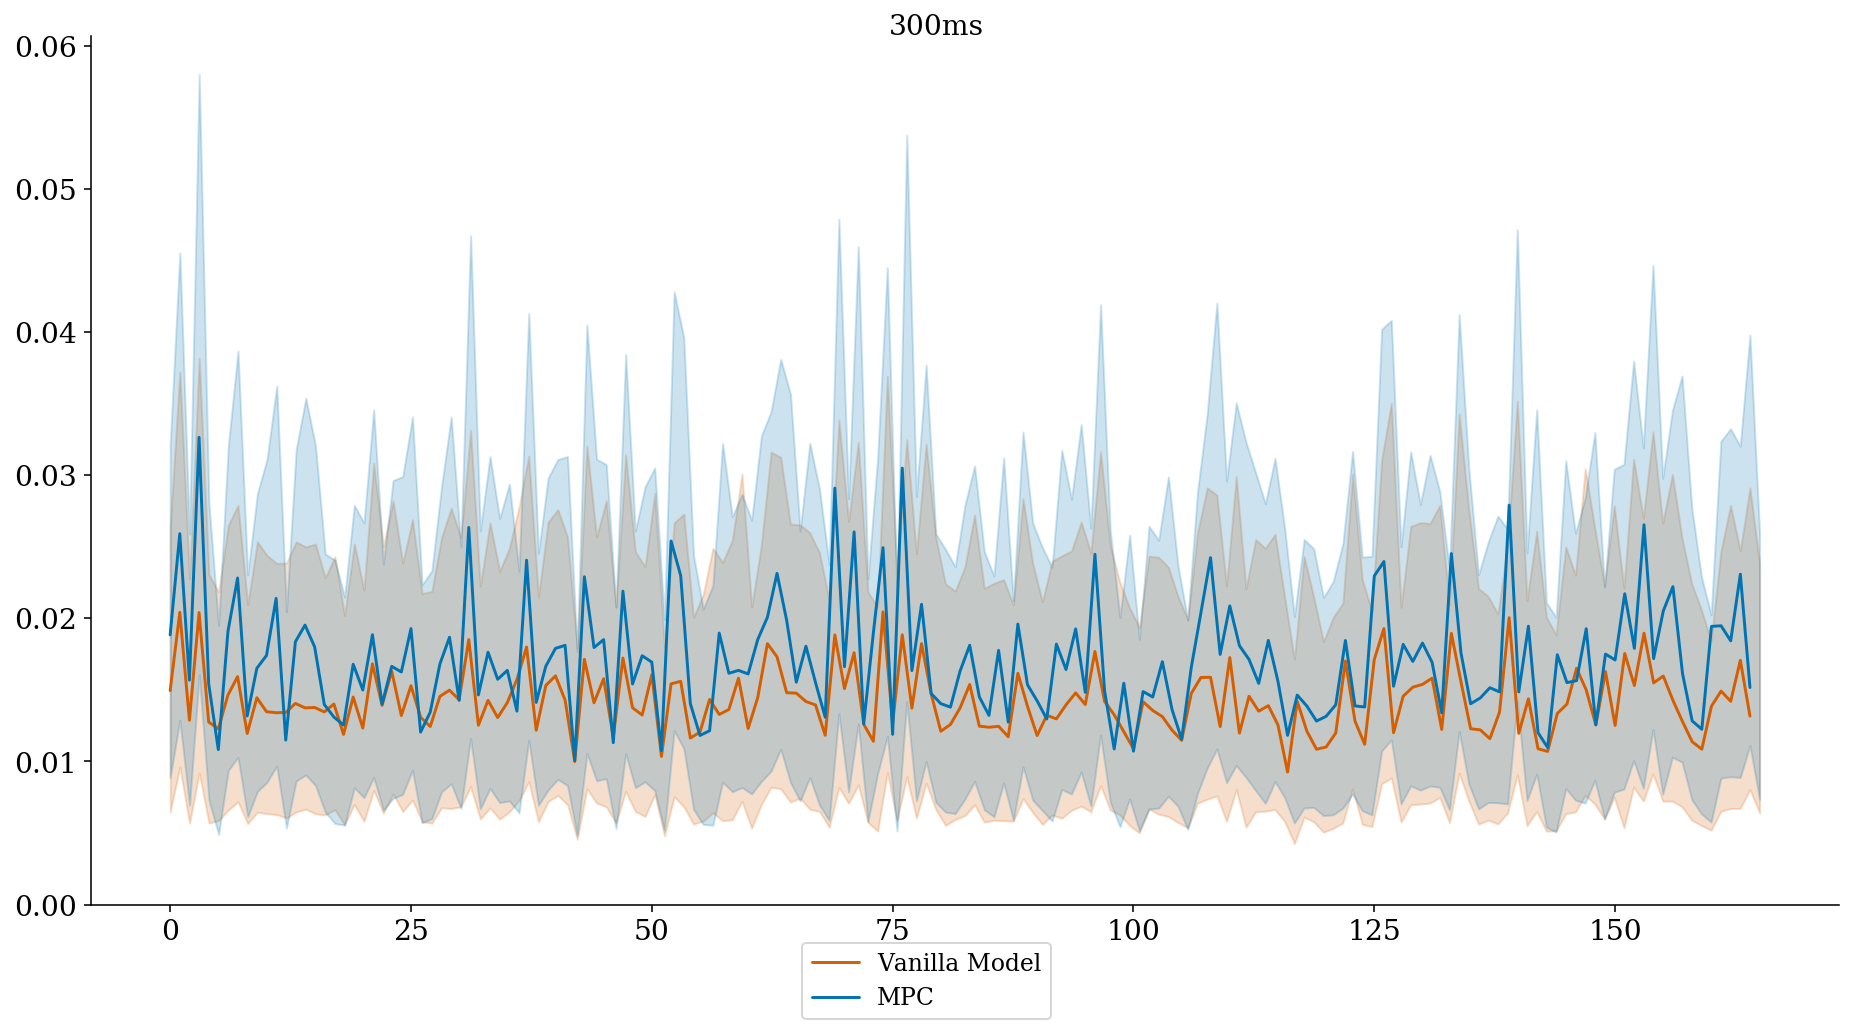

In [42]:
# Plot error for final timestep (desired target) in latent state

mpc_median = np.median(mpc_enc_prof_errors, axis = 0)
state_median = np.median(state_enc_prof_errors, axis=0)

hi_per = 75
low_per = 25

hiper_model_err = np.percentile(mpc_enc_prof_errors,hi_per,axis=0)
hiper_baseline_err = np.percentile(state_enc_prof_errors,hi_per,axis=0)

lowper_model_err = np.percentile(mpc_enc_prof_errors,low_per,axis=0)
lowper_baseline_err = np.percentile(state_enc_prof_errors,low_per,axis=0)

# Plot model vs baseline

fig, ax = plt.subplots()
psi = np.linspace(0,165,165)
    
ax.plot(state_median, label='Vanilla Model',color=colorblind_colors[1],lw=1.5)
ax.fill_between(psi,lowper_baseline_err,hiper_baseline_err,color=colorblind_colors[1],alpha=0.2)  
ax.plot(mpc_median, label='MPC', color=colorblind_colors[0], lw=1.5)
ax.fill_between(psi,lowper_model_err,hiper_model_err,color=colorblind_colors[0],alpha=0.2)    

ax.set_ylim(0,None)
#ax.set_ylabel(sig,size=16)
fig.legend(loc='lower center')
fig.suptitle("300ms",y=0.9)
fig.show()

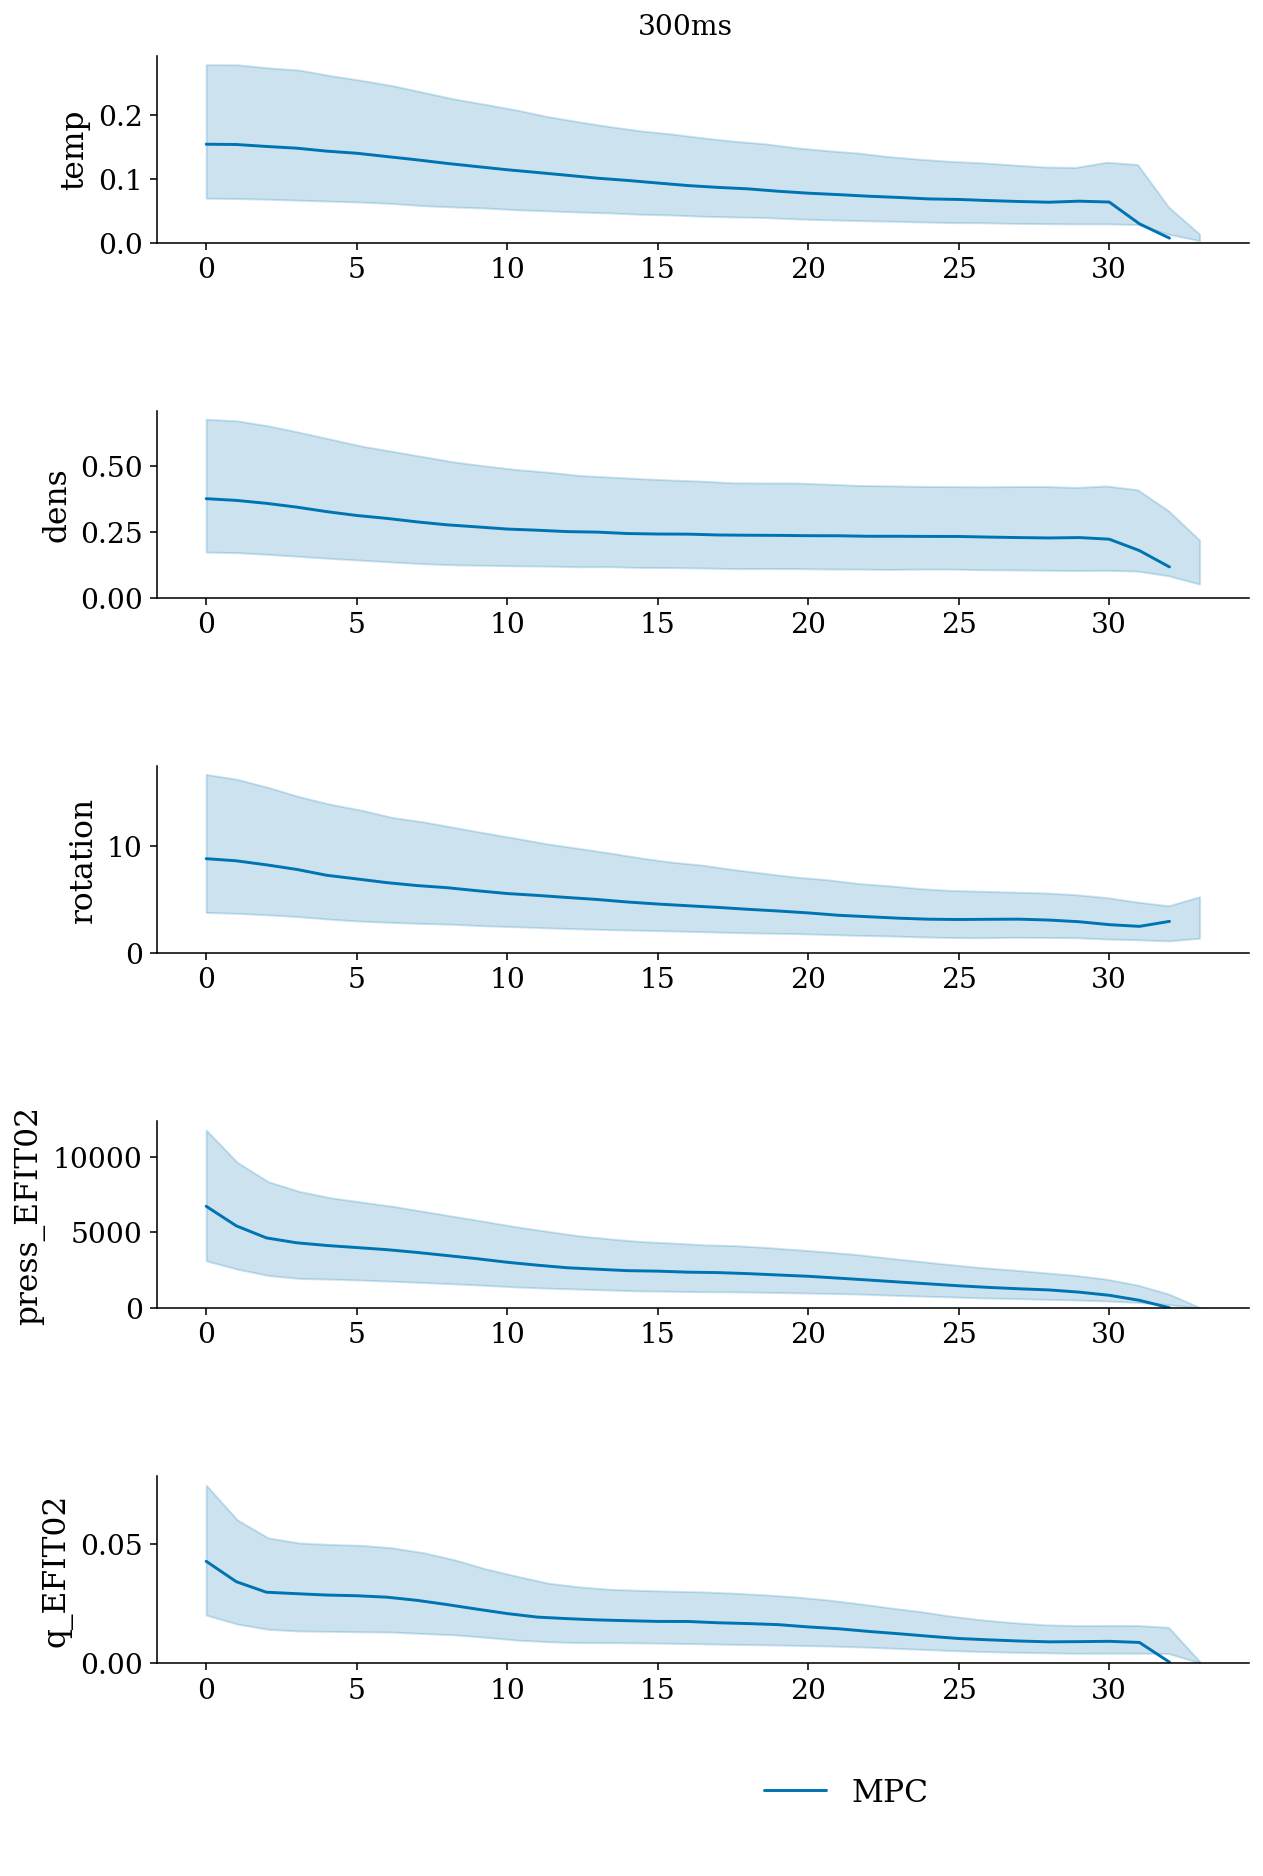

In [25]:
# Generate decoded error plots

# get median error
mpc_median = {sig:[] for sig in scenario['profile_names']}
state_median = {sig:[] for sig in scenario['profile_names']}

for sig in scenario['profile_names']:
    mpc_median[sig] = np.median(np.array(mpc_prof_errors[sig])*scenario['normalization_dict'][sig]['std'],axis=0)
    state_median[sig] = np.median(np.array(state_prof_errors[sig])*scenario['normalization_dict'][sig]['std'],axis=0)


# get percentiles
hi_per = 75
low_per = 25

hiper_model_err = {sig:np.percentile(np.array(mpc_prof_errors[sig])*scenario['normalization_dict'][sig]['std'],hi_per,axis=0) for sig in scenario['profile_names']}
hiper_baseline_err = {sig:np.percentile(np.array(state_prof_errors[sig])*scenario['normalization_dict'][sig]['std'],hi_per,axis=0) for sig in scenario['profile_names']}

lowper_model_err = {sig:np.percentile(np.array(mpc_prof_errors[sig])*scenario['normalization_dict'][sig]['std'],low_per,axis=0) for sig in scenario['profile_names']}
lowper_baseline_err = {sig:np.percentile(np.array(state_prof_errors[sig])*scenario['normalization_dict'][sig]['std'],low_per,axis=0) for sig in scenario['profile_names']}


#plot
fig, ax = plt.subplots(len(scenario['profile_names']),1,figsize=(10,15))
psi = np.linspace(0,33,33)
for i,sig in enumerate(scenario['profile_names']):
    
    ax[i].plot(state_median[sig], label='Vanilla Model',color=colorblind_colors[1],lw=1.5)
    ax[i].fill_between(psi,lowper_baseline_err[sig],hiper_baseline_err[sig],color=colorblind_colors[1],alpha=0.2)  
    ax[i].plot(mpc_median[sig], label='MPC', color=colorblind_colors[0], lw=1.5)
    ax[i].fill_between(psi,lowper_model_err[sig],hiper_model_err[sig],color=colorblind_colors[0],alpha=0.2)    

    ax[i].set_ylim(0,None)
    ax[i].set_ylabel(sig,size=16)
plt.subplots_adjust(hspace=0.9, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.06),
           frameon=False,
           mode=None,
           ncol=2,
           fontsize=16);
fig.suptitle("300ms",y=0.9)
fig.show()

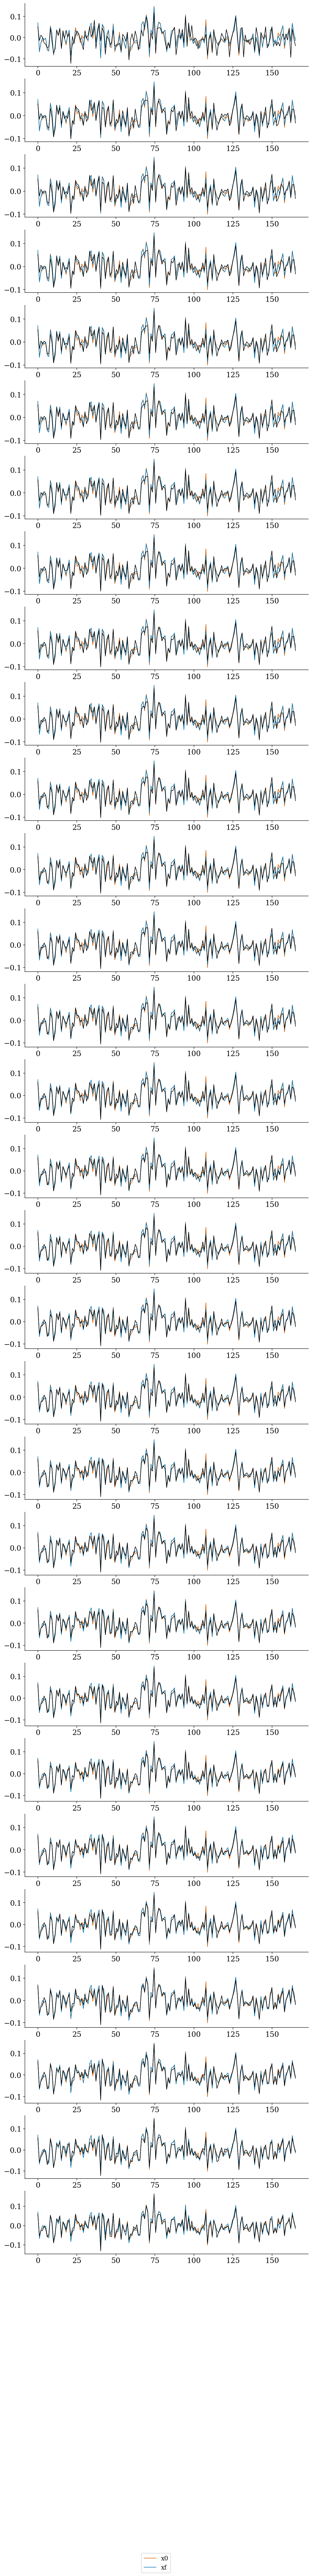

In [88]:
# Get an idea of what the control inputs are doing to the state at each timestep

state_pred, lqr_pred, state_enc_pred_arr, lqr_enc_pred_arr, sol_lqr = get_pred(0, scenario['lookahead'])
fig, ax = plt.subplots(30,1, figsize=(10,80))
psi = np.linspace(0,165,165)
   
for i in range(1,31):
    if i == 1:
        ax[i-1].plot(psi, enc_x[0], color=colorblind_colors[1],label="x0", linewidth=1)
        ax[i-1].plot(psi,  enc_XF[0], color=colorblind_colors[0], label="xf", linewidth=1)
    else: 
        ax[i-1].plot(psi, enc_x[0], color=colorblind_colors[1],linewidth=1)
        ax[i-1].plot(psi,  enc_XF[0], color=colorblind_colors[0],linewidth=1)

    ax[i-1].plot(psi, lqr_enc_pred_arr[-i], color='black', linewidth=1)
    
    

fig.legend(loc = 'lower center')
fig.show()